In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from IPython.utils import io

from utils.models.interaction_network import InteractionNetwork
from utils.data.load_graphs import load_graphs
from utils.data.graphdata import GraphDataset
from utils.evaluation.evaluate_model import evaluate_model
from utils.plotting.plot import watermark, infotext

In [4]:
nevents_range = [100, 400, 600, 1000]
nhidden_range = [3,4,5,6,7,8, 16, 32]
run = 'seg_1'
run_title = 'graph segment 1 of 3'
pz_min = 0.001
slope_max = 2.
node_dim = 2
edge_dim = 2

graph_dir = f'data/graphs_{run}_pzmin_{pz_min}_slopemax_{slope_max}'
model_dir = f'models/optimization_{run}/best'
ntest = 50
ntrials = 100


In [7]:
%%time 

aucs = np.zeros((ntrials, len(nevents_range), len(nhidden_range)))

for n in tqdm(range(ntrials)):
    with io.capture_output() as captured:
        test_data = load_graphs(graph_dir, n_graphs=ntest, node_dim=node_dim, edge_dim=edge_dim)
    test_data = GraphDataset(test_data)
    
    for i, nevents in enumerate(nevents_range):
        for j, nhidden in enumerate(nhidden_range):
            model = torch.load(f'{model_dir}/best_model_nevents_{nevents}_hidden_dim_{nhidden}.pt')
            fpr, tpr, auc = evaluate_model(model, test_data, pz_min, slope_max, ntest).get_roc()

            aucs[n,i,j] = auc

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]

CPU times: user 2.51 s, sys: 34.3 ms, total: 2.54 s
Wall time: 2.11 s


In [8]:
err = np.std(aucs, axis=0)
aucs = np.mean(aucs, axis=0)

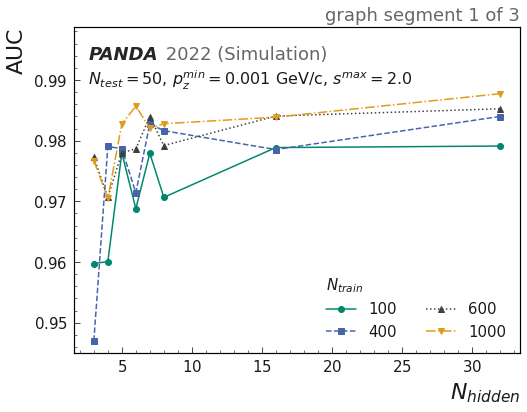

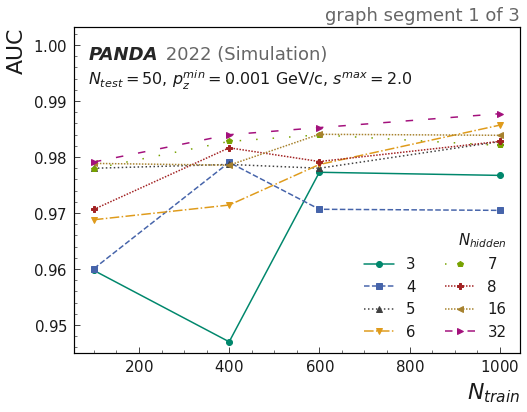

In [10]:
plt.style.use('kit')

label = ['100', '400', '600', '1000']
# for i in range(len(nevents_range)):
#     plt.errorbar(nhidden_range[2:], aucs.T[2:, i], err.T[2:, i], label=label[i]) 
plt.plot(nhidden_range, aucs.T, label=label) 
leg = plt.legend(loc='lower right', title=r'$N_{train}$', ncol=2, frameon = True, framealpha = 0.8, facecolor = 'white', edgecolor = 'white')
leg._legend_box.align = "left"
add_inf = infotext(None, pz_min, slope_max, ntest=ntest)
watermark(scale=1.2, information=add_inf)
plt.title(run_title, loc='right', color='#666666')
plt.xlabel(r'$N_{hidden}$')
plt.ylabel('AUC')
plt.savefig(f'img/3_AUC_over_Nhidden_{run}.pdf')
plt.show()

plt.style.use('kit')
plt.plot(nevents_range, aucs[:,:], label=['3','4', '5', '6', '7', '8', '16', '32']) 
leg = plt.legend(loc='lower right', title=r'$N_{hidden}$', ncol=2)
leg._legend_box.align = "right"
add_inf = infotext(None, pz_min, slope_max, ntest=ntest)
add_inf2 = 'event ID=3'
watermark(scale=1.3, information=add_inf)
plt.title(run_title, loc='right', color='#666666')
plt.xlabel(r'$N_{train}$')
plt.ylabel('AUC')
plt.savefig(f'img/3_AUC_over_Nevents_{run}.pdf')
plt.show()